In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model
import numpy as np

# Load pre-trained VGG19 model
vgg = VGG19(include_top=False, weights='imagenet')

# Define layers for content and style representations
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create a model that returns the style and content tensors
content_outputs = [vgg.get_layer(name).output for name in content_layers]
style_outputs = [vgg.get_layer(name).output for name in style_layers]
model_outputs = content_outputs + style_outputs
model = Model(inputs=vgg.input, outputs=model_outputs)

# Load and preprocess content and style images
content_img = load_img('/content/drive/MyDrive/kedi.jpg', target_size=(224, 224))
style_img = load_img('/content/drive/MyDrive/star.jpeg', target_size=(224, 224))
content_array = img_to_array(content_img)
style_array = img_to_array(style_img)
content_array = tf.keras.applications.vgg19.preprocess_input(content_array)
style_array = tf.keras.applications.vgg19.preprocess_input(style_array)
content_array = np.expand_dims(content_array, axis=0)
style_array = np.expand_dims(style_array, axis=0)

# Compute content and style features
content_features = model(content_array)[:len(content_layers)]
style_features = model(style_array)[len(content_layers):]

# Define loss functions
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

# Initialize generated image
generated_image = tf.Variable(content_array)

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Main optimization loop
for i in range(1000):
    with tf.GradientTape() as tape:
        model_outputs = model(generated_image)
        content_loss_value = content_loss(content_features[0], model_outputs[0])
        style_loss_value = 0
        for s, g in zip(style_features, model_outputs[1:]):
            style_loss_value += style_loss(s, g)
        total_loss = content_loss_value + (style_loss_value / len(style_layers))
    gradients = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    if i % 100 == 0:
        print("Iteration {}, Total loss: {:.2f}, Content loss: {:.2f}, Style loss: {:.2f}".format(
            i, total_loss, content_loss_value, style_loss_value))

# Convert generated image back to its original scale
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=255.0)
generated_image = tf.cast(generated_image, tf.uint8)

# Save or display the generated image


80134624/80134624 [==============================] - 0s 0us/step
Iteration 0, Total loss: 45935632384.00, Content loss: 0.00, Style loss: 229678170112.00
Iteration 100, Total loss: 36483084288.00, Content loss: 494.84, Style loss: 182415425536.00
Iteration 200, Total loss: 29131139072.00, Content loss: 902.56, Style loss: 145655693312.00
Iteration 300, Total loss: 22823725056.00, Content loss: 1225.21, Style loss: 114118615040.00
Iteration 400, Total loss: 17870628864.00, Content loss: 1492.43, Style loss: 89353134080.00
Iteration 500, Total loss: 14237009920.00, Content loss: 1727.22, Style loss: 71185039360.00
Iteration 600, Total loss: 11610491904.00, Content loss: 1925.03, Style loss: 58052448256.00
Iteration 700, Total loss: 9689767936.00, Content loss: 2073.66, Style loss: 48448827392.00
Iteration 800, Total loss: 8256437248.00, Content loss: 2206.69, Style loss: 41282174976.00
Iteration 900, Total loss: 7161581056.00, Content loss: 2317.26, Style loss: 35807891456.00


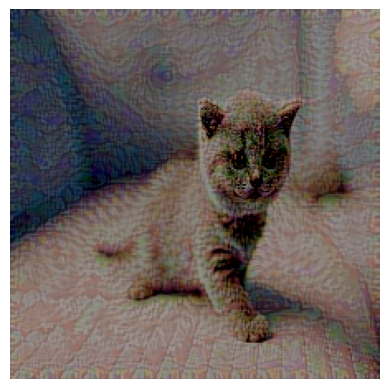

In [4]:
# Convert the generated image to numpy array
generated_image_np = generated_image.numpy()

# Remove the batch dimension
generated_image_np = np.squeeze(generated_image_np, axis=0)

# Ensure the pixel values are within valid range
generated_image_np = np.clip(generated_image_np, 0, 255)

# Convert to unsigned integer for display
generated_image_np = generated_image_np.astype(np.uint8)

# Display the generated image
plt.imshow(generated_image_np)
plt.axis('off')
plt.show()
